This lesson will focus on ransomware and cryptocurrencies. We'll look at a campaign called Deadbolt, do some survival analysis (which is useful in lots of places), and then learn a surprising decryptor key mechanism. This tutorial is inspired by the good work of 

In [3]:
import pandas as pd
import json
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (11,8)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#COLOR = 'white'
#plt.rcParams['text.color'] = 'black'
#plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['xtick.color'] = COLOR
#plt.rcParams['ytick.color'] = COLOR
import numpy as np
from lifelines import KaplanMeierFitter, NelsonAalenFitter, WeibullFitter
from lifelines.utils import median_survival_times, datetimes_to_durations

In [5]:
#Get the data on all ransoms paid
family_ransoms = pd.read_csv('/data/DeadBolt_Accounts_RANSOMS.csv',index_col='confirmed_datetime',infer_datetime_format=True,parse_dates=['confirmed_datetime','received_datetime'],low_memory=False)

/tmp/ipykernel_922122/770631043.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  family_ransoms = pd.read_csv('DeadBolt_Accounts_RANSOMS.csv',index_col='confirmed_datetime',infer_datetime_format=True,parse_dates=['confirmed_datetime','received_datetime'],low_memory=False)


In [6]:
#Reorder the data based on time...rec'vd time is closer to infection, confirmation is when the blockchain confirmed it
family_ransoms = family_ransoms.sort_values('received_datetime')

In [7]:
#Infection data from Censys.io
deadbolt_infections = [
  {
    "d": "2022-01-24",
    "count": "1"
  },
  {
    "d": "2022-01-25",
    "count": "4142"
  },
  {
    "d": "2022-01-26",
    "count": "4988"
  },
  {
    "d": "2022-01-27",
    "count": "3927"
  },
  {
    "d": "2022-01-28",
    "count": "2002"
  },
  {
    "d": "2022-01-29",
    "count": "1128"
  },
  {
    "d": "2022-01-30",
    "count": "920"
  },
  {
    "d": "2022-01-31",
    "count": "853"
  },
  {
    "d": "2022-02-01",
    "count": "783"
  },
  {
    "d": "2022-02-02",
    "count": "735"
  },
  {
    "d": "2022-02-03",
    "count": "712"
  },
  {
    "d": "2022-02-04",
    "count": "656"
  },
  {
    "d": "2022-02-05",
    "count": "627"
  }
]

In [8]:
#Turn it into two lists of infection numbers and dates
collector_list = []
for blob in deadbolt_infections:
    collector_list.append([blob['d'], int(blob['count'])])

In [10]:
#Make it a dataframe
infection_timeseries = pd.DataFrame(collector_list,columns=['Date','Count'])
infection_timeseries['Date'] = pd.to_datetime(infection_timeseries['Date'])
infection_timeseries = infection_timeseries.set_index('Date')

Now let's do a little science and test something that should be intuitive. Does the number of infections correlate to the number of ransoms paid (numerically speaking). We'll need to talk a little about 'the null hypothesis' is that they do not. We want a p_value below a 'confidence' interval to reject the null hypothesis. The correlation is a number symbolising HOW STRONGLY they correlate, but it's useless if we don't reject the null hypothesis below say a 5% confidence interval.

In [12]:
#Have to trim the ransoms to be the same length to use Pearson's
#Note this is a one day lag correlation
corr, p_value = pearsonr(infection_timeseries['Count'], family_ransoms['count'].resample('D').sum().head(13))
print('Pearsons correlation: %.3f' % corr)
print('P-value is: %.10F' % p_value)

Pearsons correlation: 0.876
P-value is: 0.0000848383


So trying to sum up our result into a single scientific sentence:
We can reject the null hypothesis that ransoms don't correlate with infections.
Or in more plain English:
There's less than a 1% chance of our scientific result occuring by accident.
So, More infections = more ransoms paid.

(array([19017., 19019., 19021., 19023., 19024., 19026., 19028.]),
 [Text(19017.0, 0, '2022-01-25'),
  Text(19019.0, 0, '2022-01-27'),
  Text(19021.0, 0, '2022-01-29'),
  Text(19023.0, 0, '2022-01-31'),
  Text(19024.0, 0, '2022-02-01'),
  Text(19026.0, 0, '2022-02-03'),
  Text(19028.0, 0, '2022-02-05')])

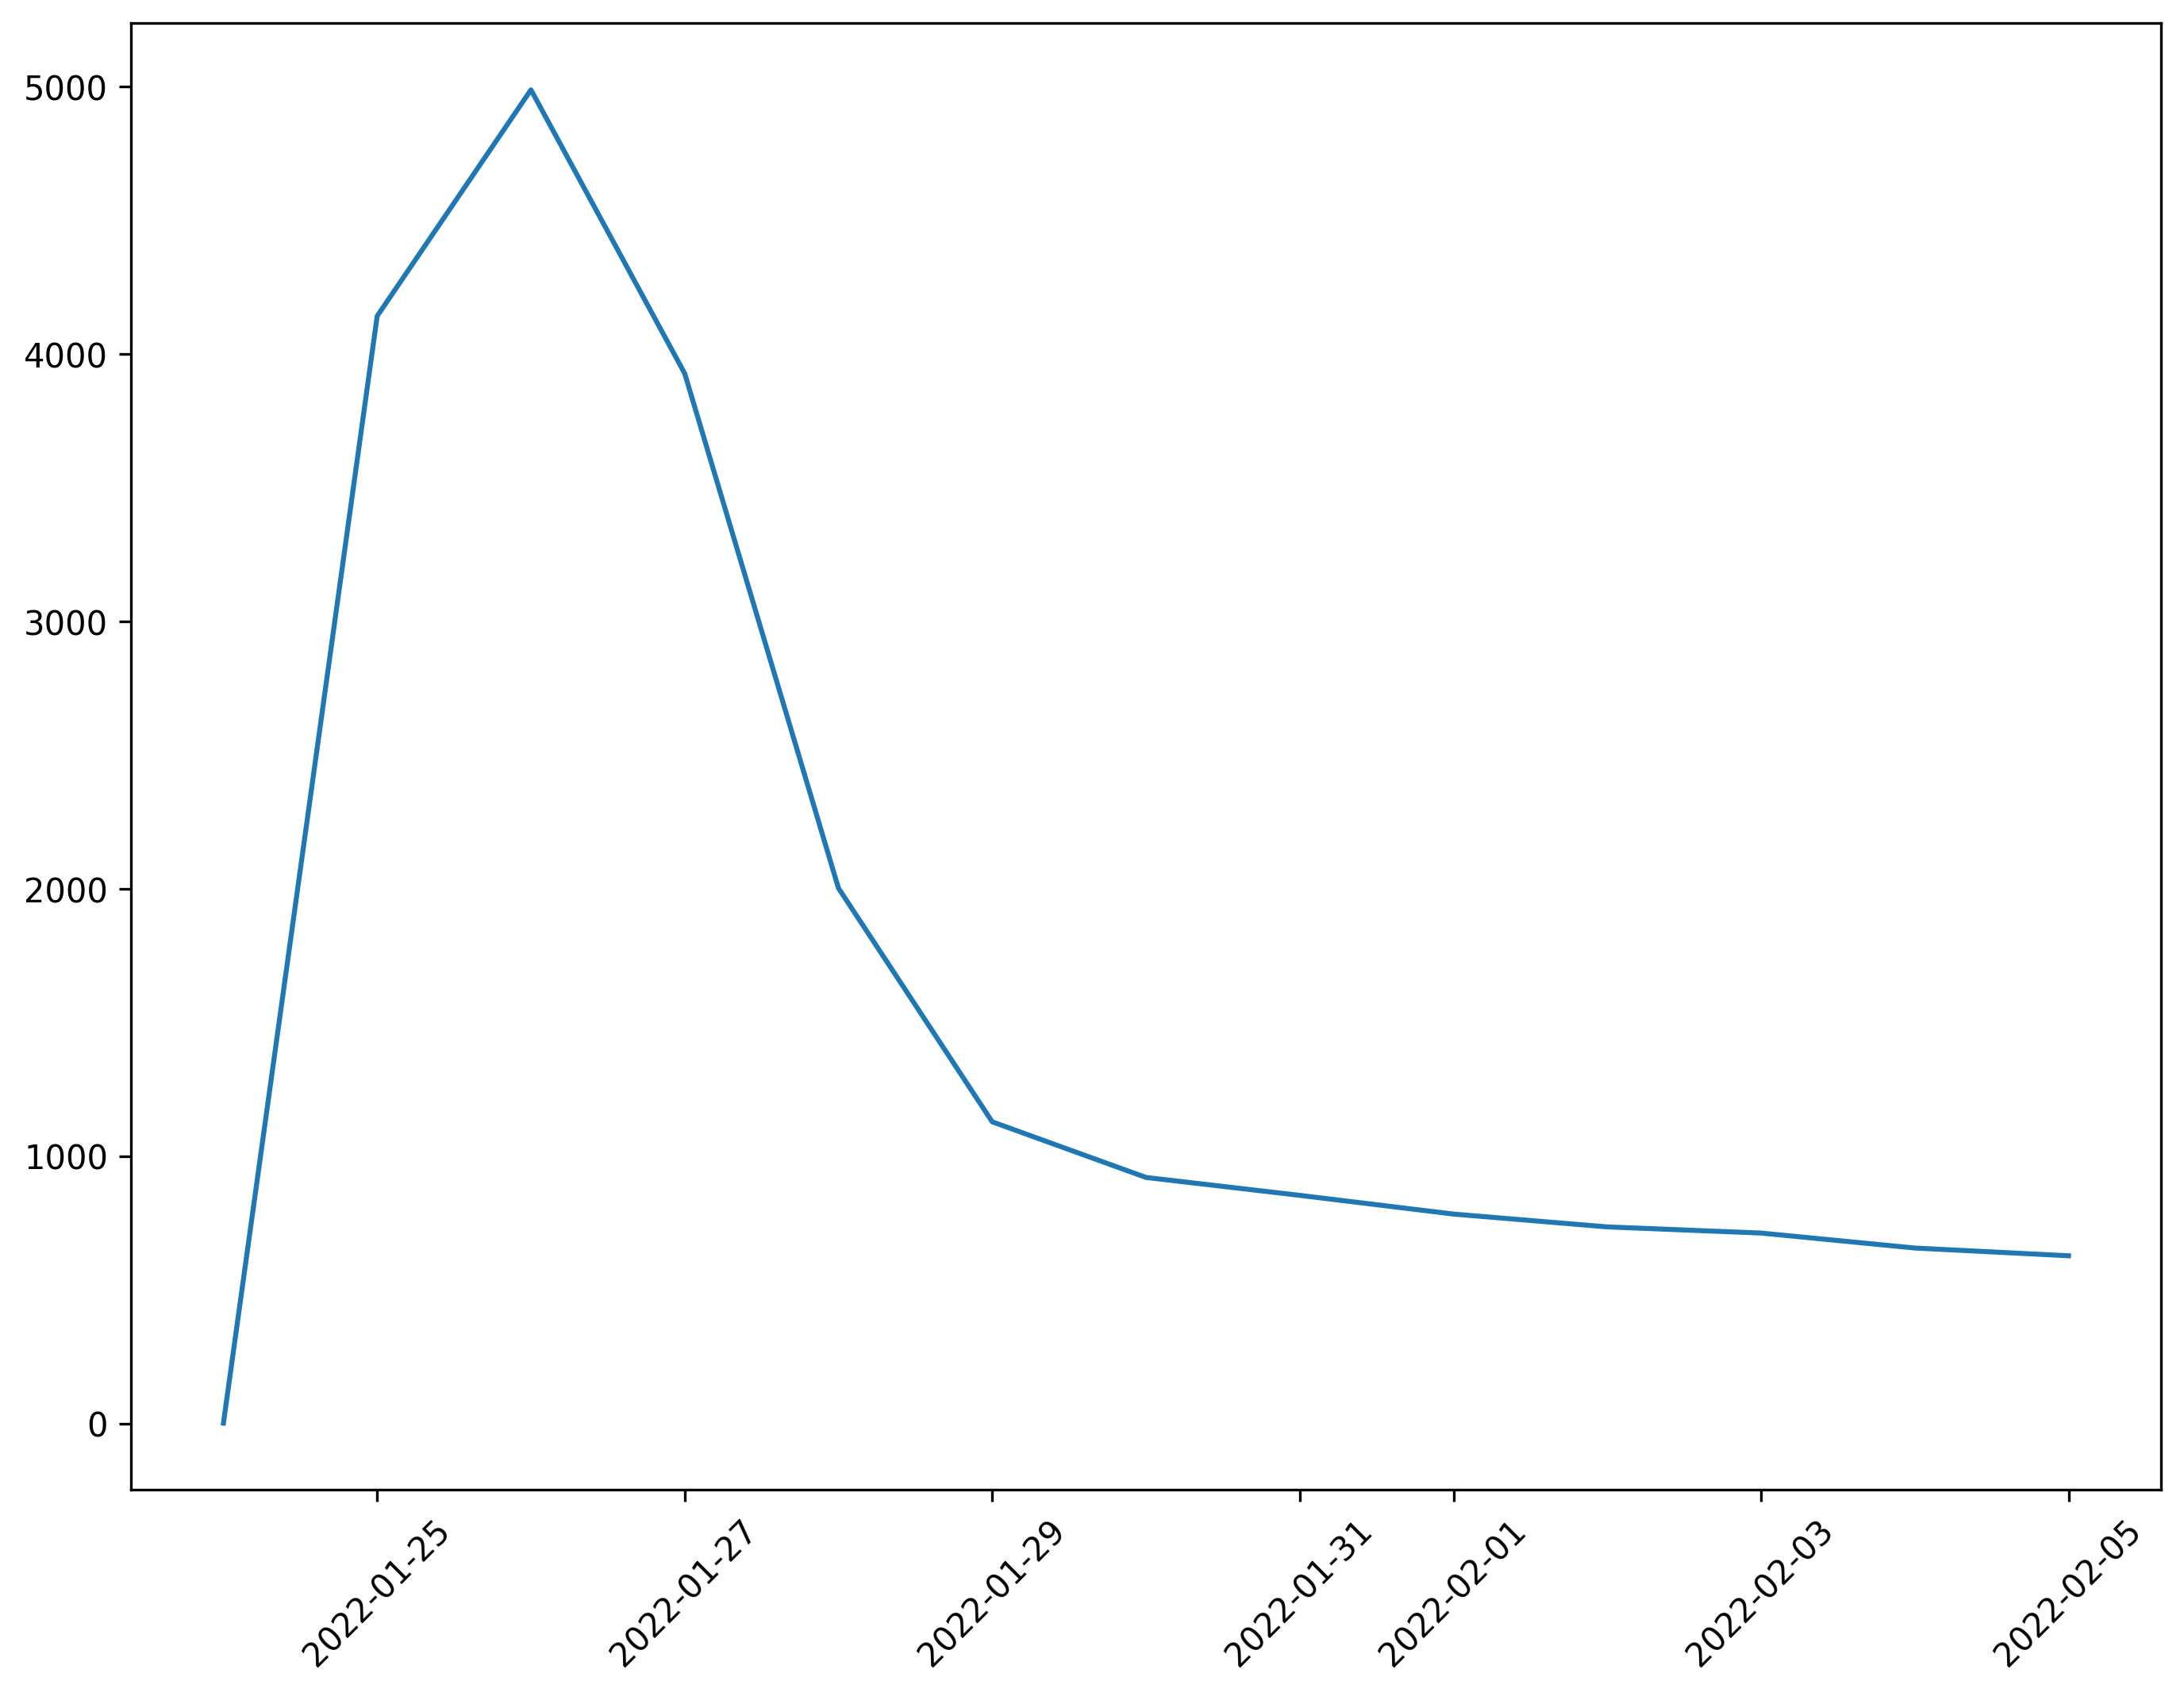

In [13]:
#Let's look at how the infections change over time
plt.plot(infection_timeseries.index,infection_timeseries['Count'], label = "Infections")
plt.xticks(rotation=45)

In [14]:
#This variable is crucial to produce a bunch of graphs below
#It is used in so many places we put it here for if you need to change it
#That happens when a new ransom paymnent rolls in
#num_days = 240
num_days = len(family_ransoms['count'].resample('D').sum())

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 [Text(-100.0, 0, '−100'),
  Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500'),
  Text(600.0, 0, '600')])

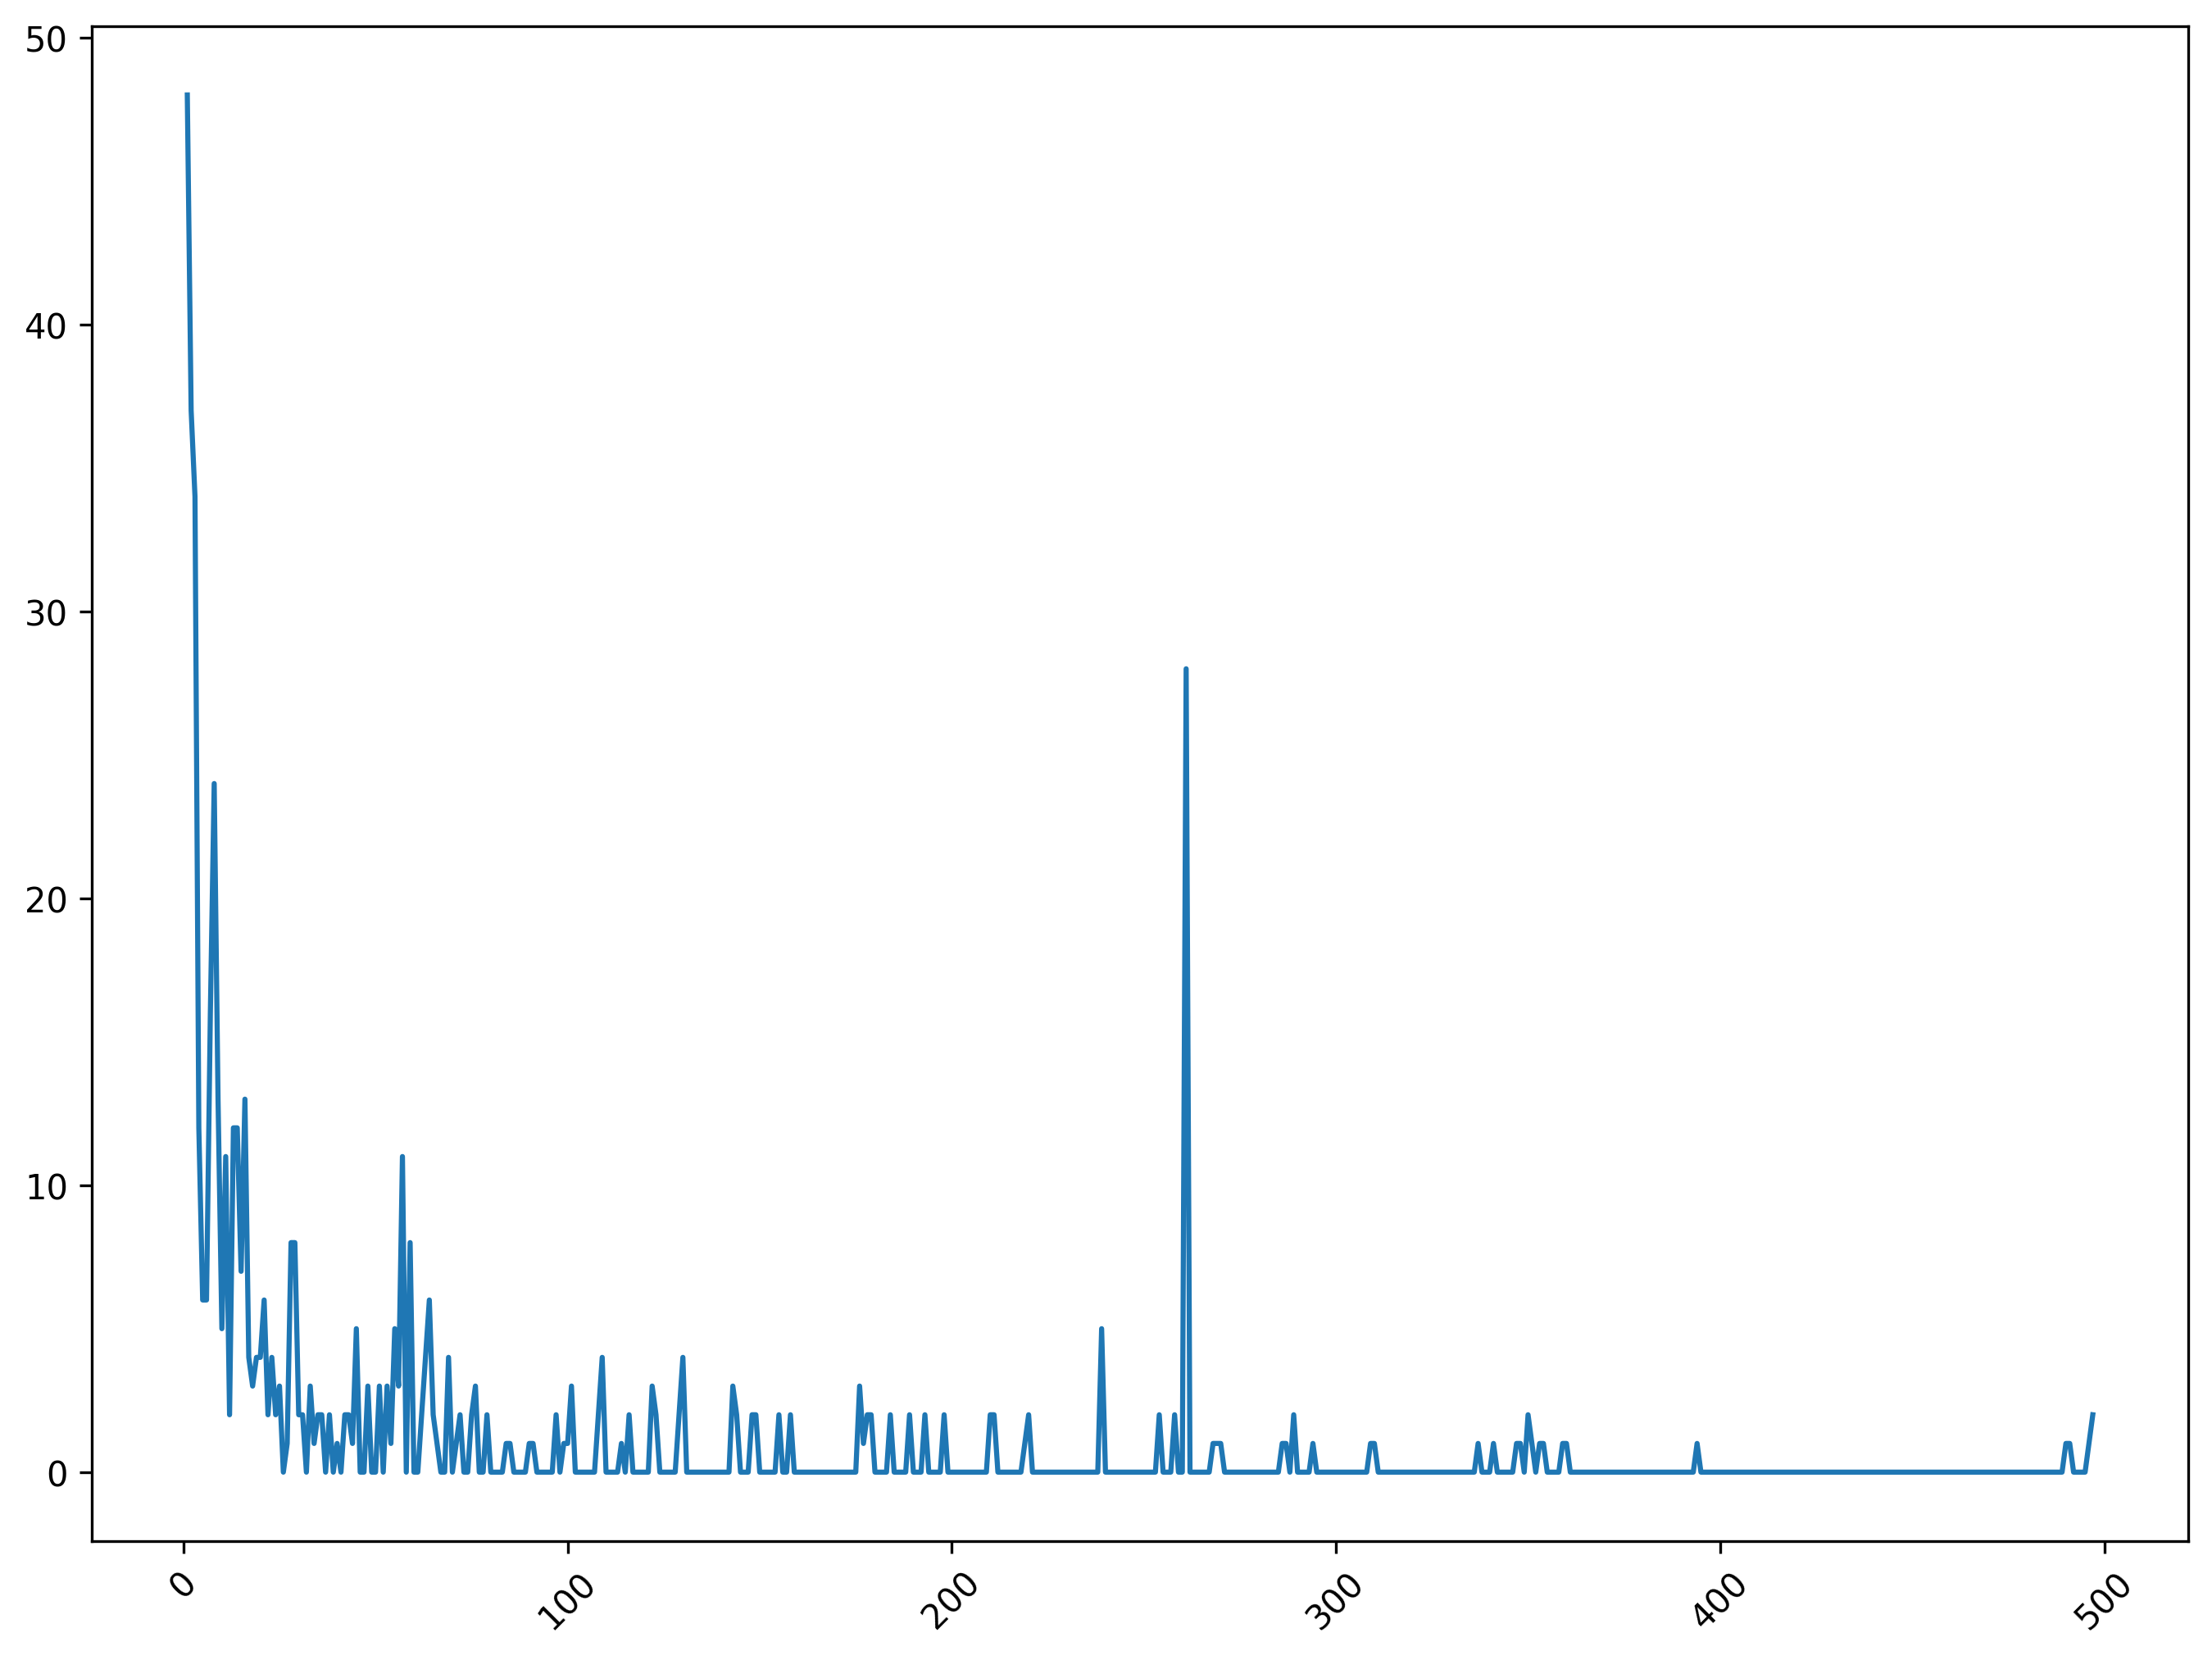

In [15]:
#Let's look at ransoms paid over time
plt.plot(np.arange(1,num_days,1),family_ransoms.resample('D').sum()['count'][1:], label = "Ransoms")
plt.xticks(rotation=45)

In [17]:
payment_list = pd.to_datetime(family_ransoms['received_datetime'],format='ISO8601').dt.date.to_list()
non_payment_list = [None]*(4988-len(payment_list))
full_list = payment_list + non_payment_list
d = {'infection':['2022-01-24']*max(infection_timeseries['Count']),'payment':full_list}
survival_analysis = pd.DataFrame(d)

Text(0, 0.5, 'Proportion of infection who did not pay ransom')

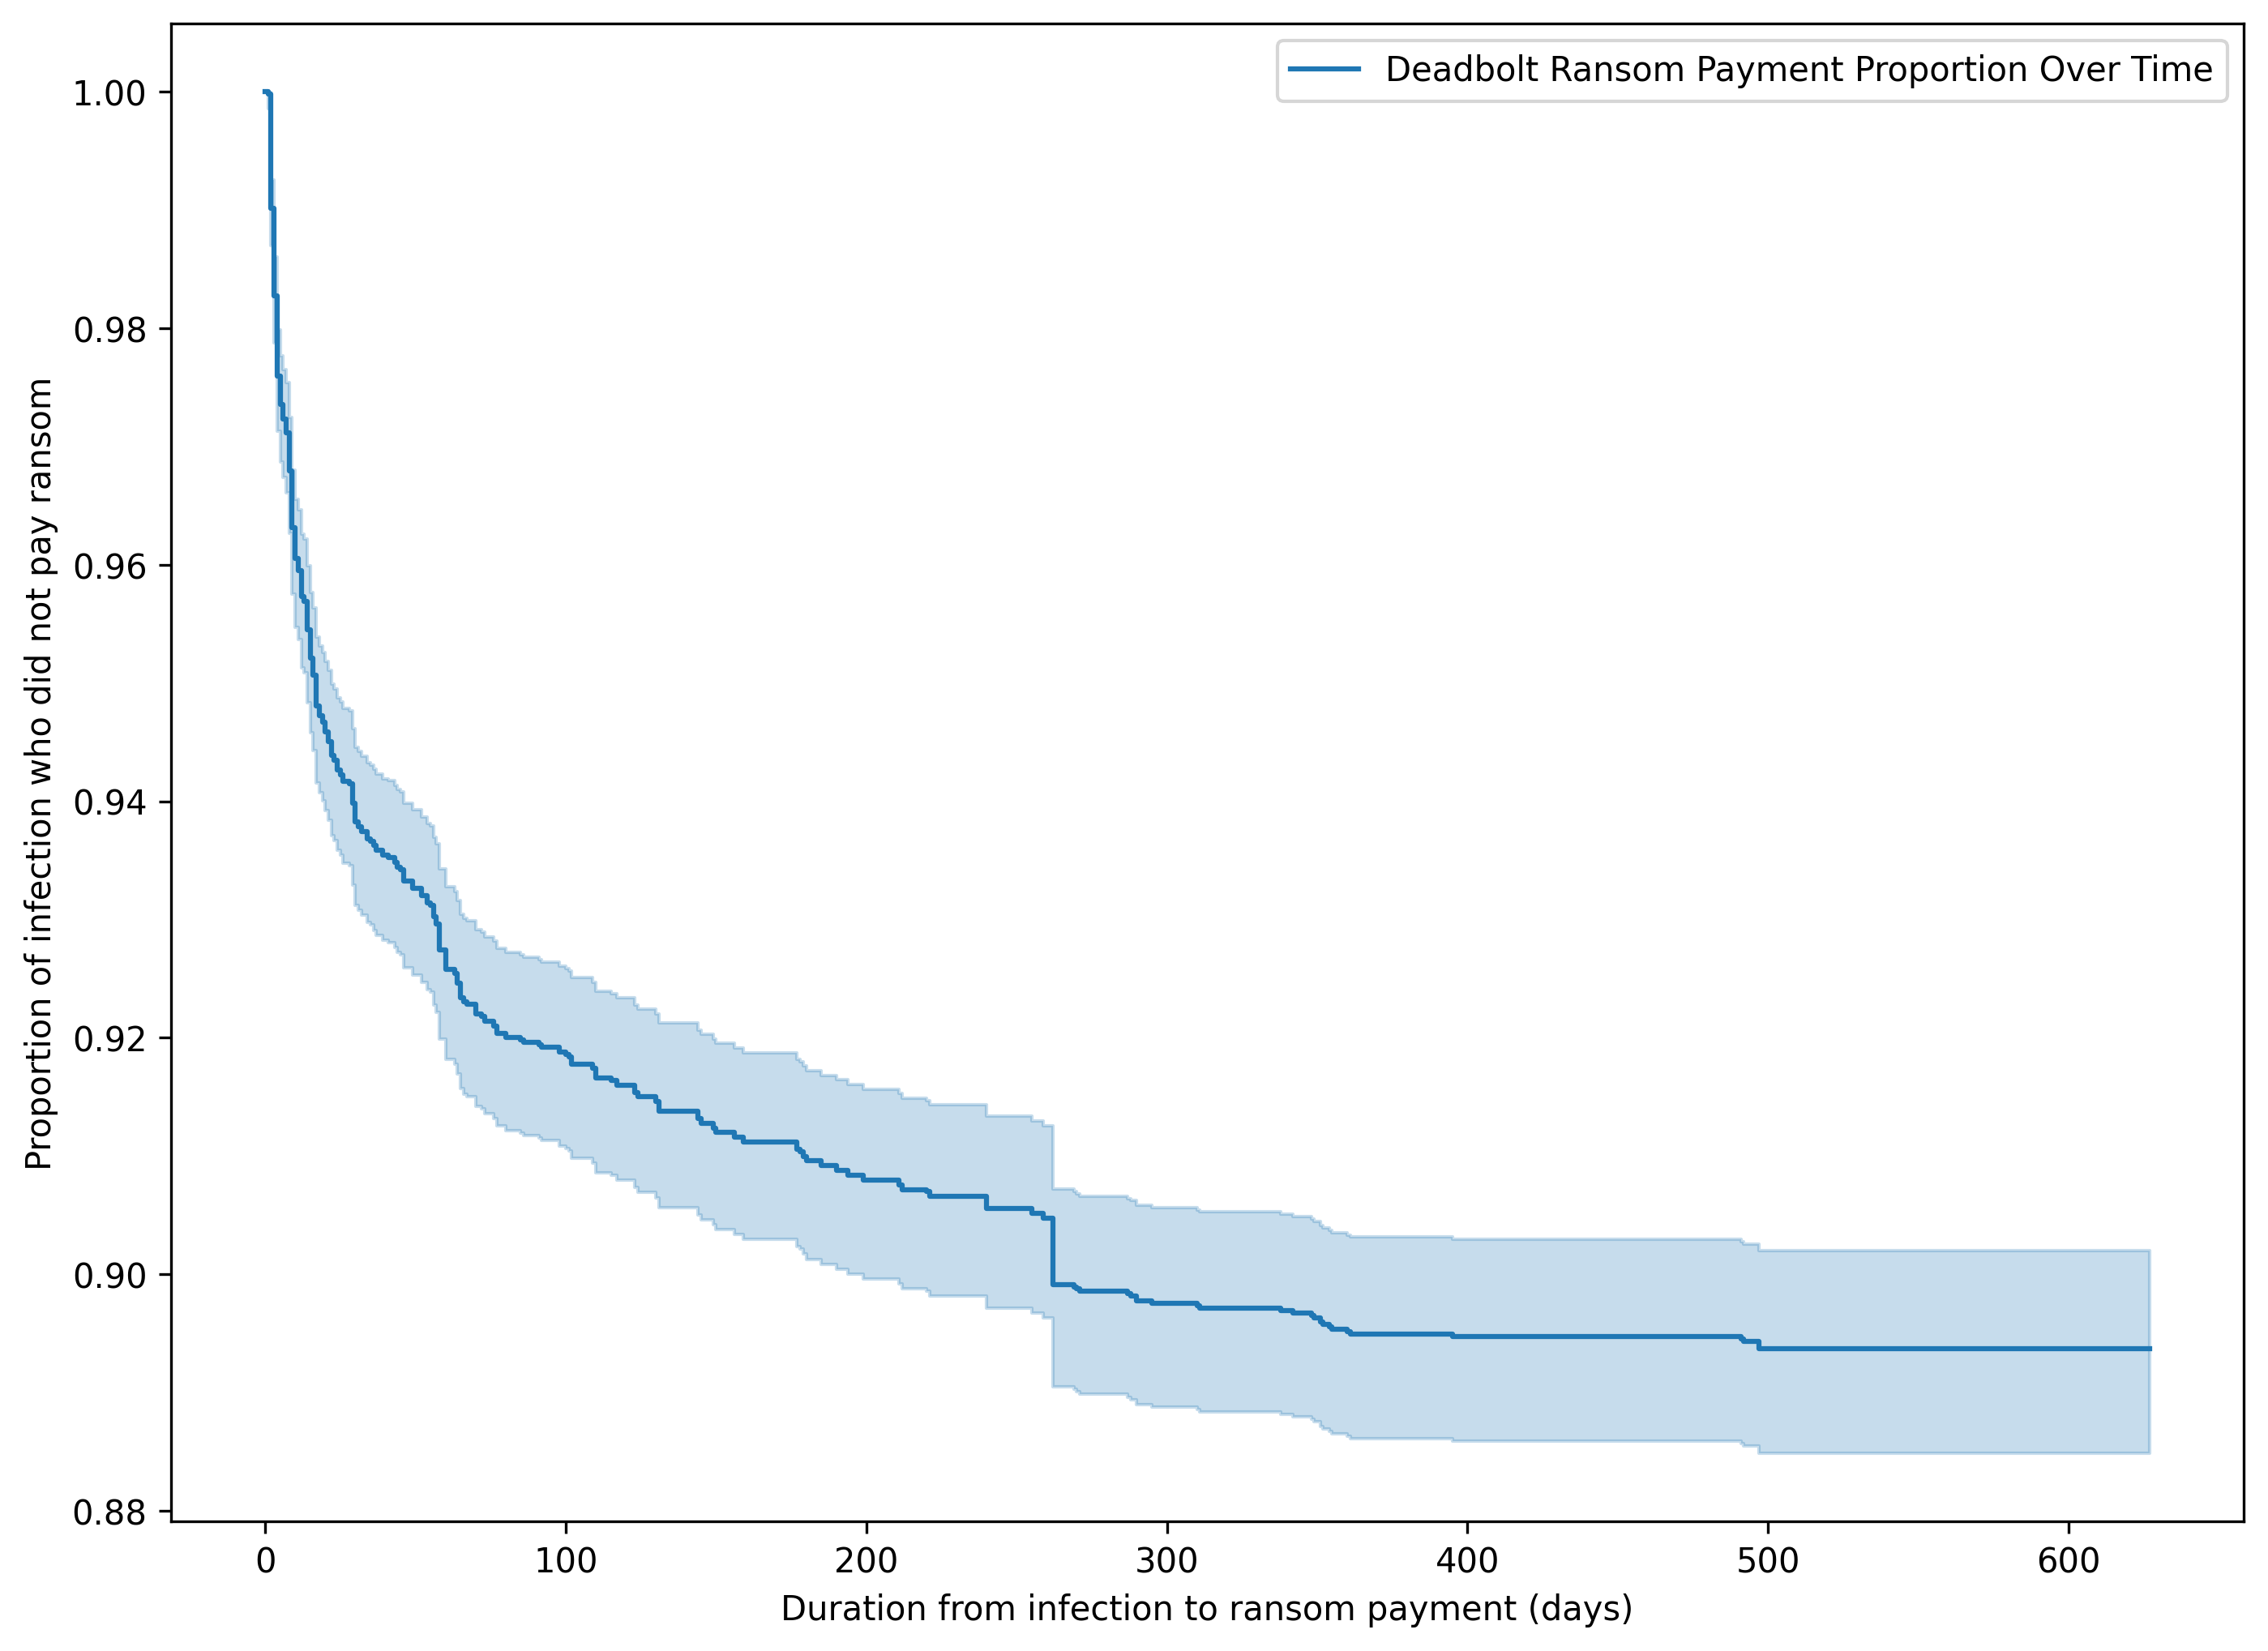

In [18]:
kmf = KaplanMeierFitter()
survival_analysis = survival_analysis.reset_index()
survival_analysis = survival_analysis[['infection','payment']]
T, E = datetimes_to_durations(survival_analysis['infection'], survival_analysis['payment'], freq='D')
kmf.fit(T, E, label='Deadbolt Ransom Payment Proportion Over Time')
kmf.plot()
plt.xlabel('Duration from infection to ransom payment (days)')
plt.ylabel('Proportion of infection who did not pay ransom')

In [19]:
kmf.confidence_interval_

,Deadbolt Ransom Payment Proportion Over Time_lower_0.95,Deadbolt Ransom Payment Proportion Over Time_upper_0.95
0.0,1.000000,1.000000
1.0,0.998578,0.999972
2.0,0.987023,0.992567
3.0,0.978744,0.986020
4.0,0.971297,0.979844
...,...,...
395.0,0.885900,0.902947
491.0,0.885693,0.902754
492.0,0.885485,0.902560
497.0,0.884863,0.901981


In [21]:
#Get the data on all transactions
# There's a very interesting BTC address in here, that both sends and recieves. Can you figure out why?
find_the_interesting_address = pd.read_csv('/data/DeadBolt_Accounts_TRXNS.csv',index_col='confirmed_datetime',infer_datetime_format=True,parse_dates=['confirmed_datetime','received_datetime'],low_memory=False)

/tmp/ipykernel_922122/2071792804.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  find_the_decryptor_address = pd.read_csv('DeadBolt_Accounts_TRXNS.csv',index_col='confirmed_datetime',infer_datetime_format=True,parse_dates=['confirmed_datetime','received_datetime'],low_memory=False)
